<a href="https://colab.research.google.com/github/Chanura04/ML-Coursework/blob/main/20240955.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
!pip install keras-tuner

In [2]:
import pandas as pd
# from google.colab import drive
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import keras_tuner as kt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras import layers, regularizers
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

## Load the dataset

In [3]:
url_x = "https://raw.githubusercontent.com/Chanura04/ML-Coursework/main/dataset/processed/X.csv"
url_y = "https://raw.githubusercontent.com/Chanura04/ML-Coursework/main/dataset/processed/y_data.csv"

## Check dataset behaviour

In [4]:
X=pd.read_csv(url_x)
y=pd.read_csv(url_y)
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,0,0,34,1,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,0,0,0,2,1,0,1,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,0,0,45,0,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0,0,2,1,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
y.head()

,Churn
0,0
1,0
2,1
3,0
4,1


In [6]:
X.shape

(7043, 26)

In [7]:
y.shape

(7043, 1)

### Split Data into Training, Validation, and Test Sets

In [8]:

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
# print(f"Shape of X_val: {X_val.shape}")
# print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (5634, 26)
Shape of y_train: (5634, 1)
Shape of X_test: (1409, 26)
Shape of y_test: (1409, 1)


#### Handle class imbalance

In [9]:
smote=SMOTE(random_state=42)
X_train,y_train=smote.fit_resample(X_train,y_train)

Text(0.5, 1.0, 'Count Plot for Churn')

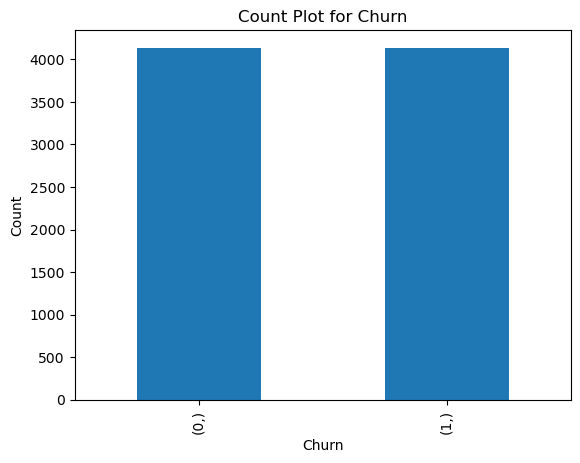

In [10]:
count=y_train.value_counts()
count.plot(kind='bar')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Count Plot for Churn')

In [11]:
def plot_history(history):
    # Loss
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Binary Crossentropy")
    plt.legend()


    # Accuracy
    plt.subplot(1,3,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()


    # AUC
    plt.subplot(1,3,3)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title("AUC Curve")
    plt.xlabel("Epochs")
    plt.ylabel("AUC Score")
    plt.legend()
    plt.show()




In [12]:
input_dim=X_train.shape[1]
input_dim

26

In [13]:
# os.makedirs("models", exist_ok=True)
#
# best_tuned_model_test_02.save("models/best_nn_model.keras")


## Decision Tree Traininig

#### Test 01

In [14]:
dt_model = DecisionTreeClassifier(
    criterion="entropy",         # Use 'entropy' for information gain
    max_depth=6,             # Prevent overfitting
    min_samples_split=40,     # Minimum samples required for a split
    min_samples_leaf=20,      # Minimum samples per leaf
  # Handle class imbalance
    random_state=42
)

# Train model
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=20,
                       min_samples_split=40, random_state=42)

In [15]:
y_pred = dt_model.predict(X_test)


In [16]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[849, 186],
       [127, 247]])

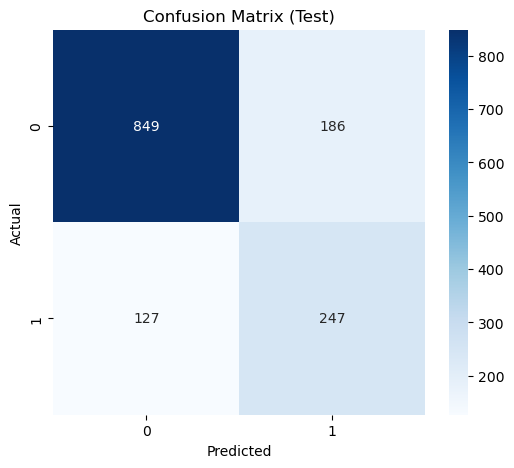

In [17]:

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [18]:
y_pred_proba_deci_1 = dt_model.predict(X_test).ravel()
y_pred_deci_1 = (y_pred_proba_deci_1 >= 0.5).astype(int)
print("Test AUC:", roc_auc_score(y_test, y_pred_proba_deci_1))
print("Test Accuracy:", accuracy_score(y_test, y_pred_deci_1))
print(classification_report(y_test, y_pred_deci_1))

Test AUC: 0.7403588312795474
Test Accuracy: 0.7778566359119943
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1035
           1       0.57      0.66      0.61       374

    accuracy                           0.78      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.78      0.78      1409



#### Test 02

In [19]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [20]:
param_dist = {
    "criterion": ["gini", "entropy"],           # Split quality measure
    "max_depth": [5, 7, 9, 11, 13, 15, 20, None],  # Tree complexity control
    "min_samples_split": [2, 5, 10, 20],        # Minimum samples to split node
    "min_samples_leaf": [1, 2, 4, 8, 16],       # Minimum samples in leaf nodes
    "max_features": [None, "sqrt", "log2"],     # Feature subset consideration
    "ccp_alpha": [0, 0.0001, 0.001, 0.01, 0.1], # Cost-complexity pruning
    "class_weight": [                           # Handling class imbalance
        None,
        "balanced",
        {0: 1, 1: 1.5},
        {0: 1, 1: 2}
    ]
}

dt = DecisionTreeClassifier(random_state=42)


rs = RandomizedSearchCV(
    dt,
    param_distributions=param_dist,
    n_iter=150,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

rs.fit(X_train, y_train)

print("Best params (random search):", rs.best_params_)
print("Best cross-val ROC AUC:", rs.best_score_)
best_dt = rs.best_estimator_


Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Best params (random search): {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 20, 'criterion': 'entropy', 'class_weight': None, 'ccp_alpha': 0.001}
Best cross-val ROC AUC: 0.9110096440922645


Test accuracy: 0.7750177430801988
Test precision: 0.571072319201995
Test recall: 0.6122994652406417
Test f1: 0.5909677419354838
Test ROC AUC: 0.818322612312382

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      1035
           1       0.57      0.61      0.59       374

    accuracy                           0.78      1409
   macro avg       0.71      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



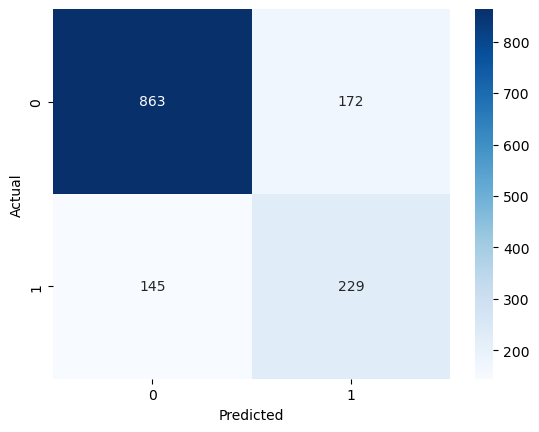

In [21]:
# use best_dt or final_dt from above
model = best_dt  # or final_dt

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test precision:", precision_score(y_test, y_pred))
print("Test recall:", recall_score(y_test, y_pred))
print("Test f1:", f1_score(y_test, y_pred))
if y_prob is not None:
    print("Test ROC AUC:", roc_auc_score(y_test, y_prob))

print("\nClassification report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


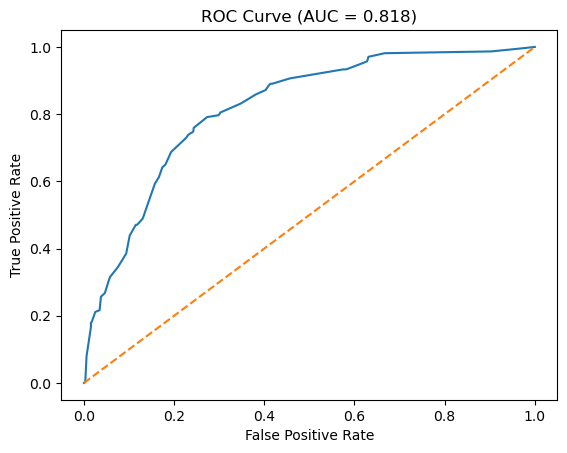

In [22]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.show()


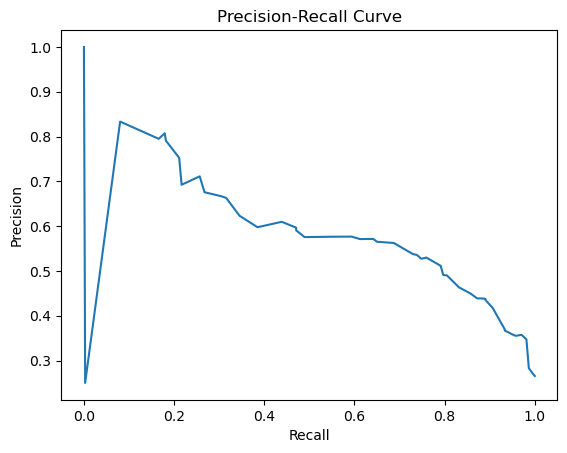

In [23]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


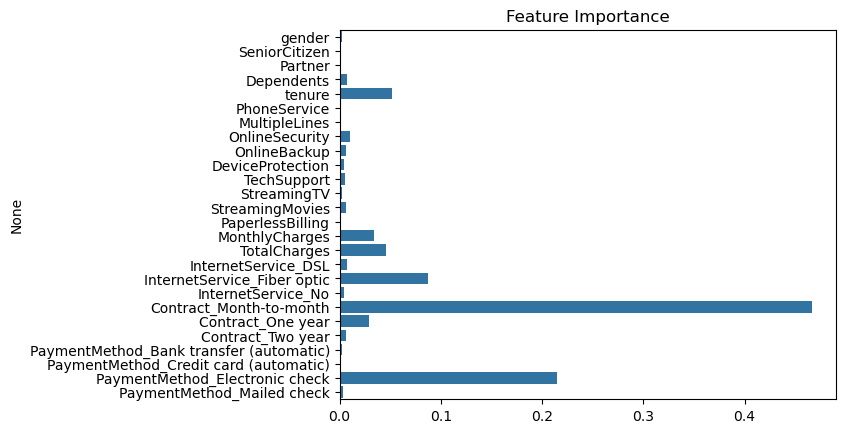

In [24]:
import pandas as pd

importances = model.feature_importances_
features = X_train.columns

sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()


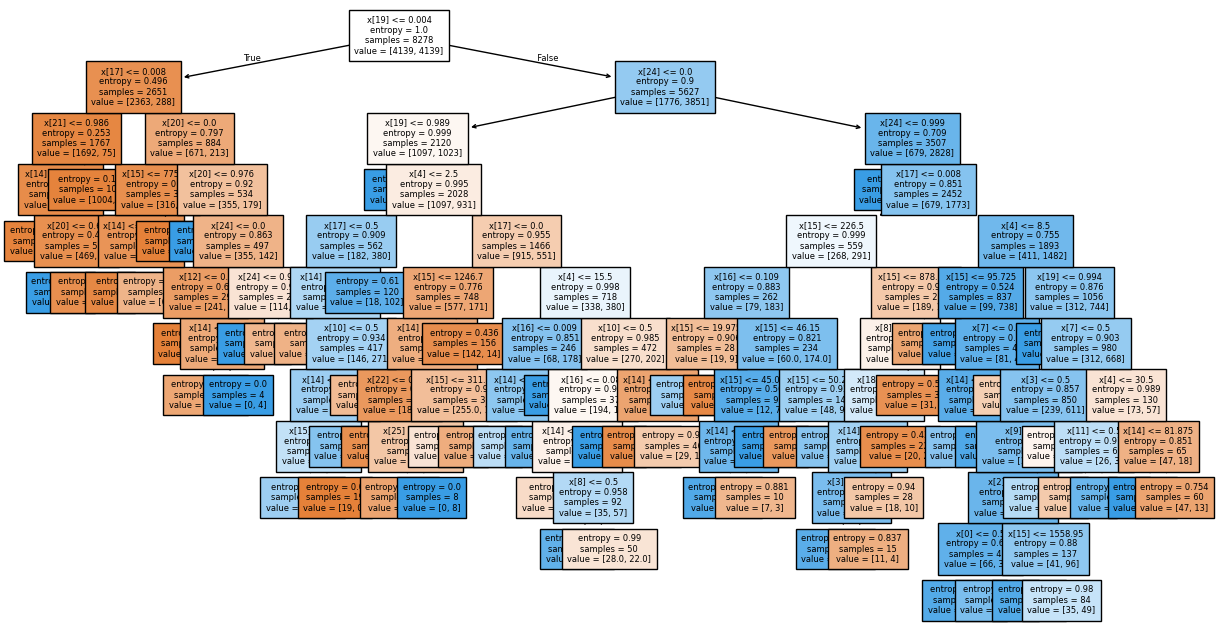

In [25]:
from sklearn import tree
plt.figure(figsize=(15, 8))
tree.plot_tree(model, filled=True, fontsize=6)
plt.show()


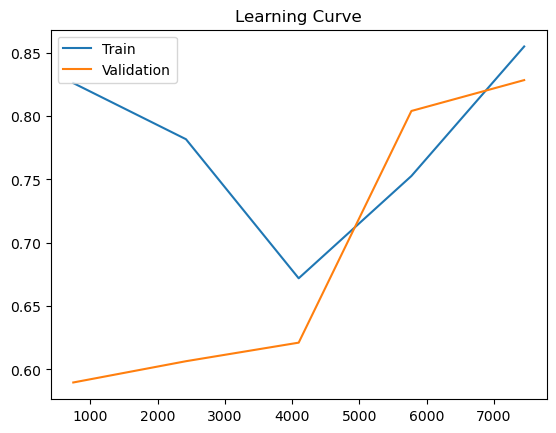

In [26]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train, cv=cv, scoring="f1"
)

plt.plot(train_sizes, train_scores.mean(axis=1), label="Train")
plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation")
plt.legend()
plt.title("Learning Curve")
plt.show()


#### Test 3

In [27]:
from scipy.stats import randint, uniform

param_dist = {
    "criterion": ["gini", "entropy"],
    "max_depth": randint(3, 40),           # shallow to deep
    "min_samples_split": randint(2, 50),   # min samples to split
    "min_samples_leaf": randint(1, 30),    # leaf size
    "max_features": [None, "sqrt", "log2"],
    "ccp_alpha": uniform(0.0, 0.02),       # small alphas for pruning
    # "class_weight": [None, "balanced"]
    "class_weight": [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 2, 1: 1}, "balanced"]

}
 

In [28]:
dt = DecisionTreeClassifier(random_state=42)


rs = RandomizedSearchCV(
    dt,
    param_distributions=param_dist,
    n_iter=150,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

rs.fit(X_train, y_train)

print("Best params (random search):", rs.best_params_)
print("Best cross-val ROC AUC:", rs.best_score_)
best_dt = rs.best_estimator_


Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Best params (random search): {'ccp_alpha': np.float64(0.0016269756128379953), 'class_weight': {0: 1, 1: 2}, 'criterion': 'entropy', 'max_depth': 21, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 23}
Best cross-val ROC AUC: 0.9066700568588256


Test accuracy: 0.7494677075940384
Test precision: 0.519774011299435
Test recall: 0.7379679144385026
Test f1: 0.6099447513812155
Test ROC AUC: 0.8121896716525873

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.75      0.82      1035
           1       0.52      0.74      0.61       374

    accuracy                           0.75      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.79      0.75      0.76      1409



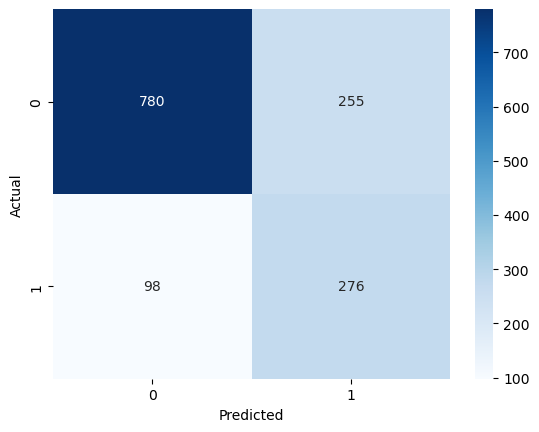

In [35]:
model = best_dt  # or final_dt

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test precision:", precision_score(y_test, y_pred))
print("Test recall:", recall_score(y_test, y_pred))
print("Test f1:", f1_score(y_test, y_pred))
if y_prob is not None:
    print("Test ROC AUC:", roc_auc_score(y_test, y_prob))

print("\nClassification report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [36]:
cm

array([[780, 255],
       [ 98, 276]])

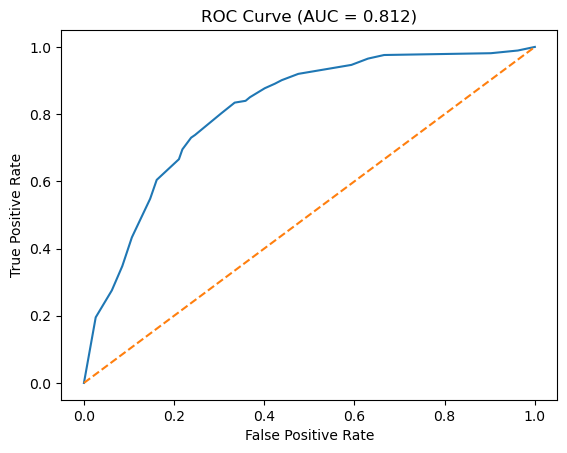

In [30]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.show()

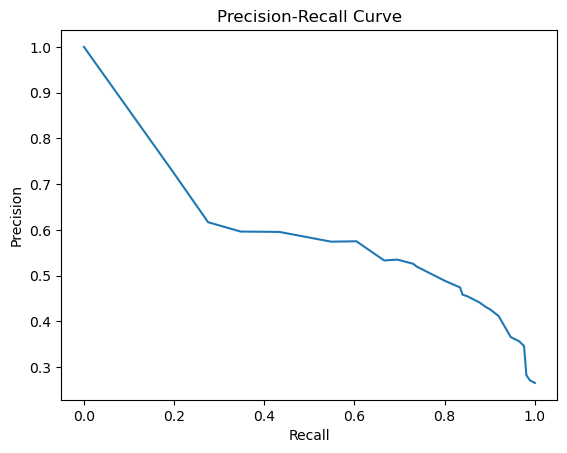

In [31]:

from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


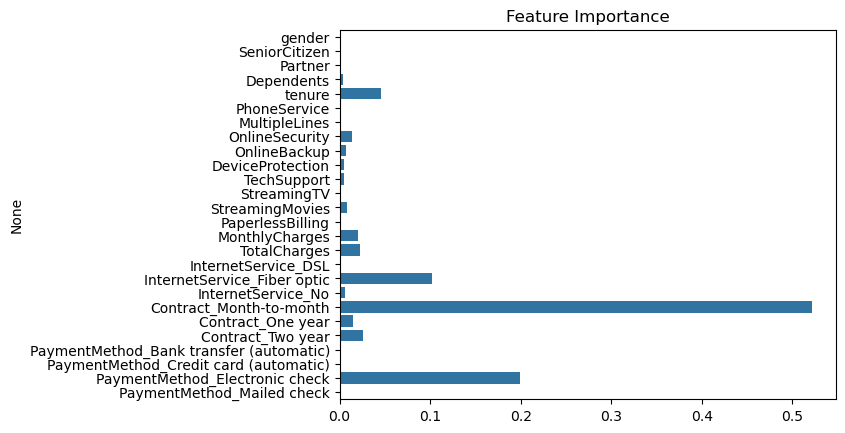

In [32]:
import pandas as pd

importances = model.feature_importances_
features = X_train.columns

sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()


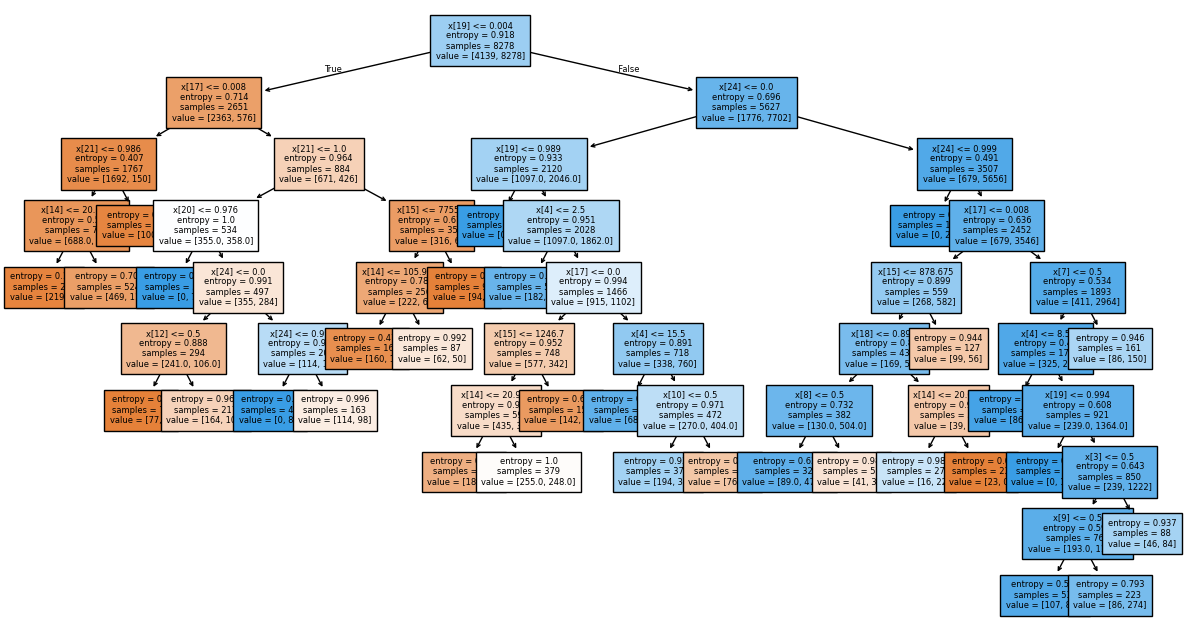

In [33]:
from sklearn import tree
plt.figure(figsize=(15, 8))
tree.plot_tree(model, filled=True, fontsize=6)
plt.show()


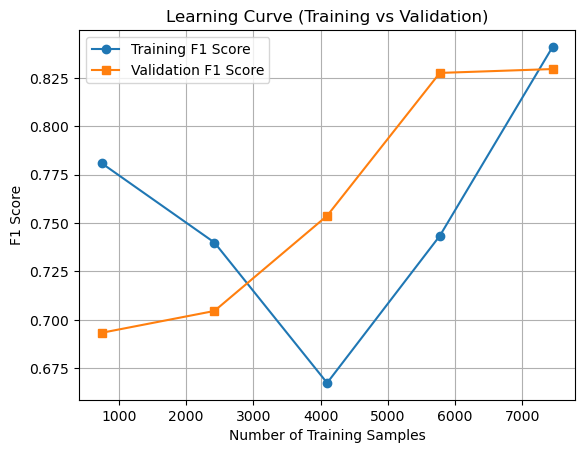

In [34]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train, cv=cv, scoring="f1"
)

# Plot mean scores
plt.plot(train_sizes, train_scores.mean(axis=1), label="Training F1 Score", marker="o")
plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation F1 Score", marker="s")

# Add labels and title
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.title("Learning Curve (Training vs Validation)")
plt.legend()
plt.grid(True)
plt.show()